In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import pandas as pd
from pylab import meshgrid
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns


## 1-D optimization

Number of uncategorized data points = 0


/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_8339/3576714500.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_set['nan']=df_set['nan'][(np.abs(test_pts['min_x']-i) > 0.01)]
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_8339/3576714500.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_set['nan']=df_set['nan'][(np.abs(test_pts['min_x']-i) > 0.01)]
/var/folders/wf/y9cx3rgx4m7bjxnkd2c3j_bh0000gn/T/ipykernel_8339/3576714500.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_set['nan']=df_set['nan'][(np.abs(test_pts['min_x']-i) > 0.01)]


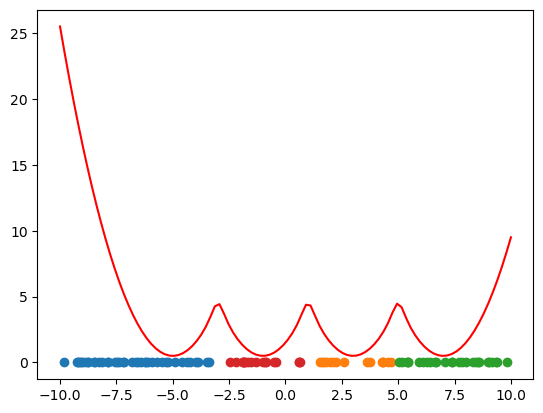

In [2]:
def potential_eqn(x, data, sigma=1):
  num=0
  denum=0
  for i in range(len(data)):
    num+=(x-data[i])**2 * np.exp(-(x-data[i])**2/sigma)
    denum+=np.exp(-(x-data[i])**2/sigma)
  return num/denum + .5

min=[-5,3,7,-1]
sigma=1

def compute_min(init_x, method='BFGS'):
    result=minimize(potential_eqn, init_x, args=(min,sigma), method=method)
    return result['x'][0]

optimize_method='CG'
xmax=10
xmin=-10
test_pts = pd.DataFrame([random.random() * (xmax-xmin) + xmin for i in range(100)], columns=['init_x'])
test_pts['min_x']=test_pts.apply(lambda x, method=optimize_method: compute_min(x['init_x'],method), axis=1)

df_set={}
df_set['nan']=test_pts
for i in min:
    df_set[i]=test_pts[np.abs(test_pts['min_x']-i) < 0.01]
    df_set['nan']=df_set['nan'][(np.abs(test_pts['min_x']-i) > 0.01)]
print("Number of uncategorized data points = {}".format(len(df_set['nan'])))

# plotting
x = np.linspace(-10, 10, 100)
plt.plot(x, potential_eqn(x,min,sigma), color='red')
for idx in min:
    plt.scatter(df_set[idx]['init_x'].to_numpy(), [0 for i in range(len(df_set[idx]))])
plt.scatter(df_set['nan']['init_x'].to_numpy(), [0 for i in range(len(df_set['nan']))])
plt.show()


## 2-D optimization

In [3]:
def potential_eqn(xs, data, sigma=1):
  num=0
  denum=0
  for i in range(len(data)):
    dist=np.linalg.norm(xs-data[i])
    num+=dist**2 * np.exp(-dist**2/sigma)
    denum+=np.exp(-dist**2/sigma)
  return num/denum

def compute_min(init_x, data, sigma, method='BFGS'):
    result=minimize(potential_eqn, init_x, args=(data,sigma), method=method)
    return result['x']

### Toy experiment 

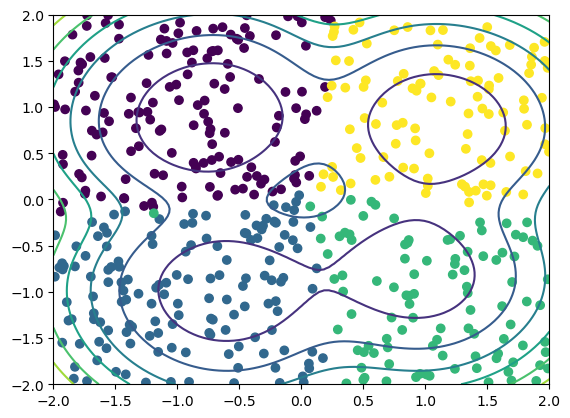

In [4]:
# defining toy model
num_testpts=500
min=[np.array([1,0.7]),np.array([-0.5,-0.9]),np.array([-0.65,0.8]),np.array([0.8,-0.7])]

# setting minimization config
my_sigma=0.7
my_method='CG'
xmax=2
xmin=-2

# creating test points 
test_pts = pd.DataFrame({'init_f1': [random.random() * (xmax-xmin) + xmin for i in range(num_testpts)], 'init_f2': [random.random() * (xmax-xmin) + xmin for i in range(num_testpts)]})
# computing the minima they belong to 
ans=test_pts.apply(lambda x: compute_min([x['init_f1'],x['init_f2']],min,my_sigma,my_method), axis=1)
for i in range(len(ans[0])):
  test_pts['min_f{}'.format(i+1)]=ans.str[i]

# creating labels based on the minima the data point belongs to
test_pts=test_pts.sort_values(by=['min_f1','min_f2']) # sort and scan through the list; set new label if the next point is different
tmp_f1=float('nan')
tmp_f2=float('nan')
set_tmp=True
tmp_label=0
list_label=[]
for index, row in test_pts.iterrows():
    if(set_tmp==True):
       tmp_f1=row['min_f1']
       tmp_f2=row['min_f2']
       set_tmp=False
    dist=np.linalg.norm(np.array(row['min_f1'],row['min_f2'])-np.array(tmp_f1,tmp_f2))
    if(dist<0.02):
       list_label.append(tmp_label)
    else:
       tmp_label+=1
       list_label.append(tmp_label)
       tmp_f1=row['min_f1']
       tmp_f2=row['min_f2']    

# plotting
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X,Y = meshgrid(x, y)
Z = np.array([[potential_eqn(np.array([i,j]), min, my_sigma) for i in x] for j in y])

fig, ax = plt.subplots(1, 1) 
ax.contour(X, Y, Z) 
plt.scatter(test_pts['init_f1'].to_numpy(), test_pts['init_f2'].to_numpy(), c=list_label)
plt.show()

## Proof of concept with Crab dataset 
link to dataset: https://www.stats.ox.ac.uk/pub/PRNN/crabs.dat


In [5]:
df_crabs = pd.read_table("crabs.dat", sep="\s+", usecols=[0,1,3,4,5,6,7], skiprows=1, names=['sp', 'sex', 'FL', 'RW', 'CL', 'CW', 'BD'])
df_crabs['true_label']=(df_crabs['sp']=='O')*2+(df_crabs['sex']=='F')
print(df_crabs)

    sp sex    FL    RW    CL    CW    BD  true_label
0    B   M   8.1   6.7  16.1  19.0   7.0           0
1    B   M   8.8   7.7  18.1  20.8   7.4           0
2    B   M   9.2   7.8  19.0  22.4   7.7           0
3    B   M   9.6   7.9  20.1  23.1   8.2           0
4    B   M   9.8   8.0  20.3  23.0   8.2           0
..  ..  ..   ...   ...   ...   ...   ...         ...
195  O   F  21.4  18.0  41.2  46.2  18.7           3
196  O   F  21.7  17.1  41.7  47.2  19.6           3
197  O   F  21.9  17.2  42.6  47.4  19.5           3
198  O   F  22.5  17.2  43.0  48.7  19.8           3
199  O   F  23.1  20.2  46.2  52.5  21.1           3

[200 rows x 8 columns]


In [6]:
## Uncomment to plotting the raw features, which are terrible for clustering
# for f1 in ['FL', 'RW', 'CL', 'CW', 'BD']:
#     for f2 in ['FL', 'RW', 'CL', 'CW', 'BD']:
#         plt.show(plt.scatter(df_crabs[f1],df_crabs[f2], c=df_crabs['true_label']))

In [7]:
df_crabs[['FL', 'RW', 'CL', 'CW', 'BD']]

,FL,RW,CL,CW,BD
0,8.1,6.7,16.1,19.0,7.0
1,8.8,7.7,18.1,20.8,7.4
2,9.2,7.8,19.0,22.4,7.7
3,9.6,7.9,20.1,23.1,8.2
4,9.8,8.0,20.3,23.0,8.2
...,...,...,...,...,...
195,21.4,18.0,41.2,46.2,18.7
196,21.7,17.1,41.7,47.2,19.6
197,21.9,17.2,42.6,47.4,19.5
198,22.5,17.2,43.0,48.7,19.8


In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_crabs[['FL', 'RW', 'CL', 'CW', 'BD']])


    sp sex    FL    RW    CL    CW    BD  true_label     umap_0    umap_1  \
0    B   M   8.1   6.7  16.1  19.0   7.0           0   1.654975  6.843830   
1    B   M   8.8   7.7  18.1  20.8   7.4           0   1.748827  6.750694   
2    B   M   9.2   7.8  19.0  22.4   7.7           0   1.758208  6.846915   
3    B   M   9.6   7.9  20.1  23.1   8.2           0   2.028508  6.704569   
4    B   M   9.8   8.0  20.3  23.0   8.2           0   2.033257  6.814912   
..  ..  ..   ...   ...   ...   ...   ...         ...        ...       ...   
195  O   F  21.4  18.0  41.2  46.2  18.7           3  17.633255  2.304229   
196  O   F  21.7  17.1  41.7  47.2  19.6           3  17.771984  2.506028   
197  O   F  21.9  17.2  42.6  47.4  19.5           3  17.877661  2.611460   
198  O   F  22.5  17.2  43.0  48.7  19.8           3  17.865677  2.757697   
199  O   F  23.1  20.2  46.2  52.5  21.1           3  17.968075  2.696112   

       umap_2    umap_3  
0    2.628837  7.953343  
1    2.555203  7.808287

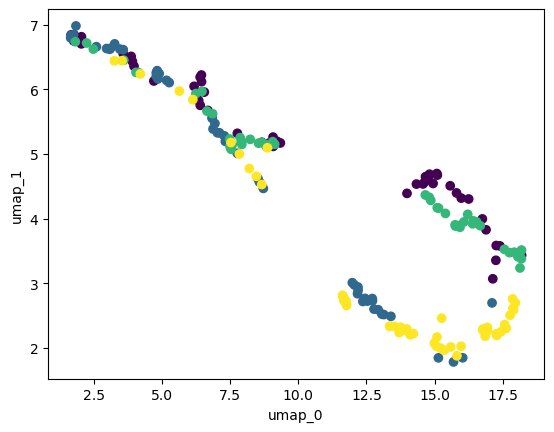

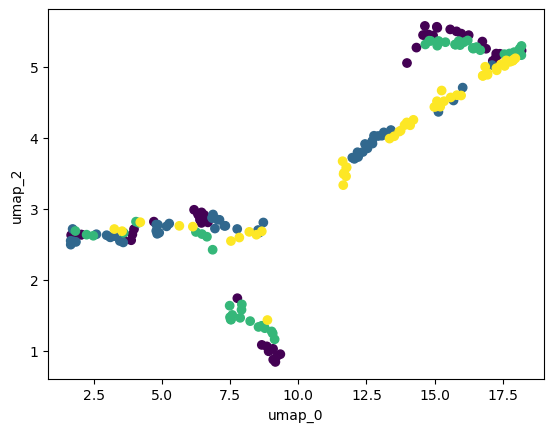

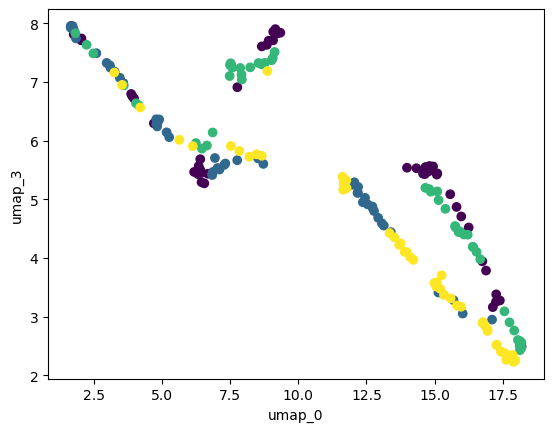

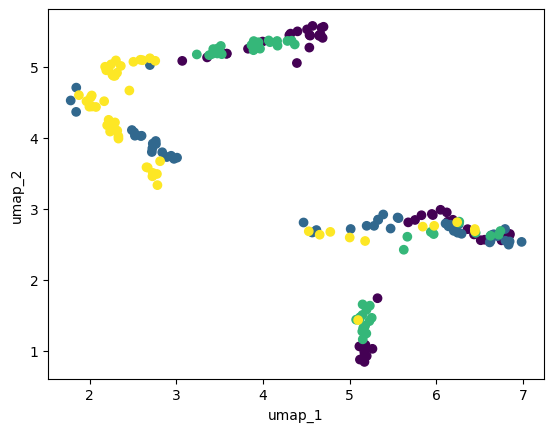

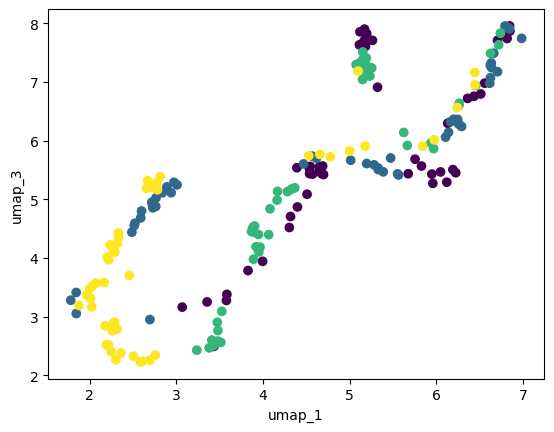

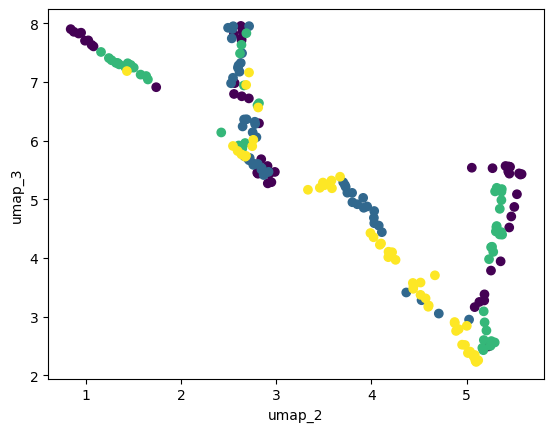

In [9]:
# Using U-MAP to get two projected features for clustering test
reducer = umap.UMAP(n_components=df_crabs['true_label'].nunique()) #VGG adjust the components
embedding = reducer.fit_transform(scaled_features)
# print(embedding.shape)
for i in range(embedding.shape[1]):
  df_crabs["umap_{}".format(i)]=embedding[:, i]
print(df_crabs)

for i in range(embedding.shape[1]):
    for j in range(i+1,embedding.shape[1]):
        plt.scatter(embedding[:, i],embedding[:, j], c=df_crabs['true_label'])
        plt.xlabel("umap_{}".format(i))
        plt.ylabel("umap_{}".format(j))
        plt.show()



    sp sex    FL    RW    CL    CW    BD  true_label     umap_0    umap_1  \
0    B   M   8.1   6.7  16.1  19.0   7.0           0   1.654975  6.843830   
1    B   M   8.8   7.7  18.1  20.8   7.4           0   1.748827  6.750694   
2    B   M   9.2   7.8  19.0  22.4   7.7           0   1.758208  6.846915   
3    B   M   9.6   7.9  20.1  23.1   8.2           0   2.028508  6.704569   
4    B   M   9.8   8.0  20.3  23.0   8.2           0   2.033257  6.814912   
..  ..  ..   ...   ...   ...   ...   ...         ...        ...       ...   
195  O   F  21.4  18.0  41.2  46.2  18.7           3  17.633255  2.304229   
196  O   F  21.7  17.1  41.7  47.2  19.6           3  17.771984  2.506028   
197  O   F  21.9  17.2  42.6  47.4  19.5           3  17.877661  2.611460   
198  O   F  22.5  17.2  43.0  48.7  19.8           3  17.865677  2.757697   
199  O   F  23.1  20.2  46.2  52.5  21.1           3  17.968075  2.696112   

       umap_2    umap_3     pca_0     pca_1     pca_2     pca_3  
0    2.62

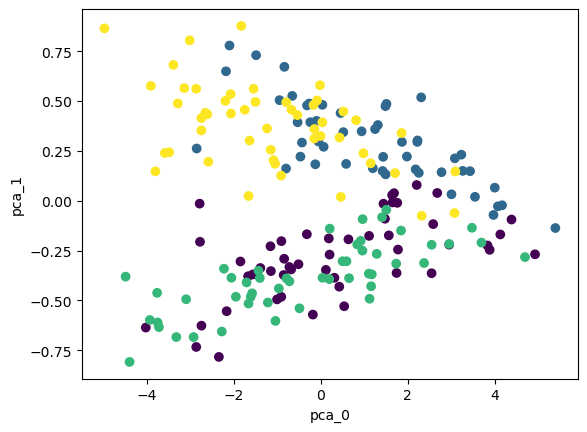

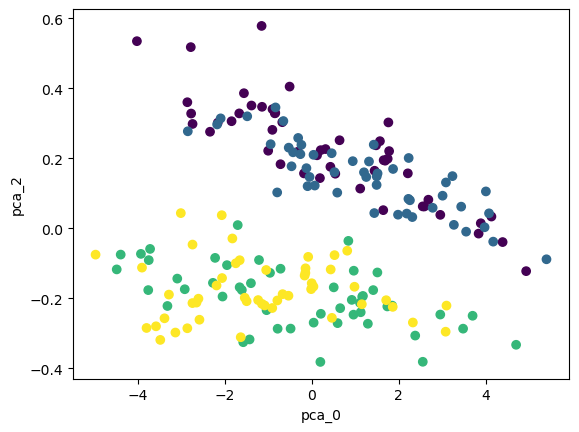

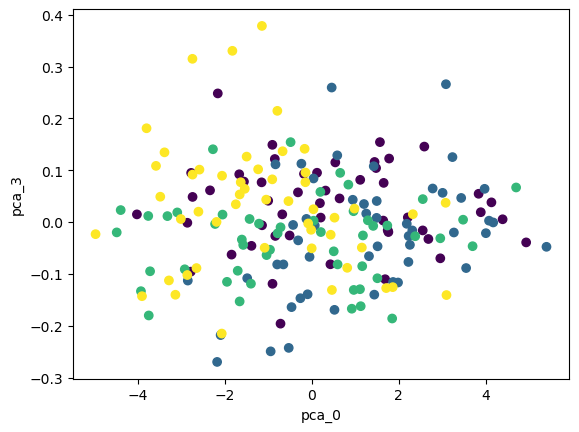

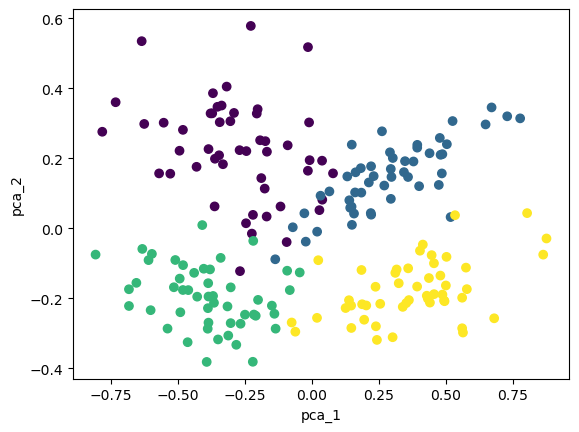

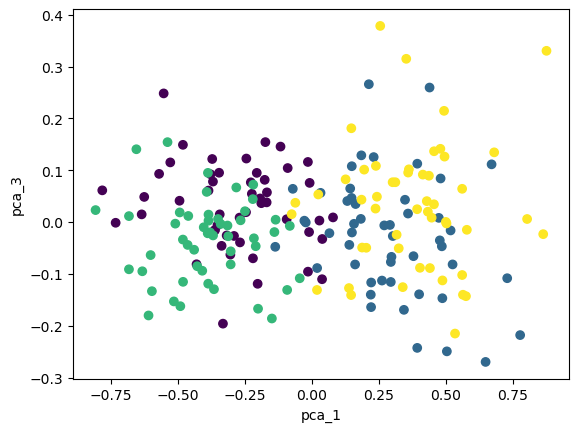

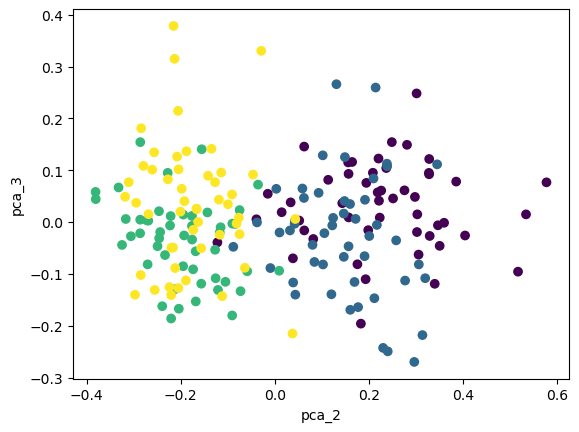

In [10]:
# Using PCA to get two projected features for clustering test
pca = PCA(n_components=df_crabs['true_label'].nunique()) 
features_pca = pca.fit_transform(scaled_features)
# pca.n_components_
# print(features_pca.shape)
for i in range(pca.n_components_):
  df_crabs["pca_{}".format(i)]=features_pca[:, i]
print(df_crabs)

for i in range(pca.n_components_):
  for j in range(i+1,pca.n_components_):
    plt.scatter(features_pca[:, i],features_pca[:, j], c=df_crabs['true_label'])
    plt.xlabel("pca_{}".format(i))
    plt.ylabel("pca_{}".format(j))
    plt.show()


In [11]:
# Set the choice of components for the clustering 2-d plane
component_for_x=1
component_for_y=2

my_sigma=0.06
my_method='BFGS'

ans=df_crabs.apply(lambda x: compute_min([x['pca_{}'.format(component_for_x)],x['pca_{}'.format(component_for_y)]],df_crabs[['pca_{}'.format(component_for_x), 'pca_{}'.format(component_for_y)]].to_numpy(),my_sigma,my_method), axis=1)
for i in range(len(ans[0])):
  df_crabs['min_f{}'.format(i+1)]=ans.str[i]

print(df_crabs)

    sp sex    FL    RW    CL    CW    BD  true_label     umap_0    umap_1  \
0    B   M   8.1   6.7  16.1  19.0   7.0           0   1.654975  6.843830   
1    B   M   8.8   7.7  18.1  20.8   7.4           0   1.748827  6.750694   
2    B   M   9.2   7.8  19.0  22.4   7.7           0   1.758208  6.846915   
3    B   M   9.6   7.9  20.1  23.1   8.2           0   2.028508  6.704569   
4    B   M   9.8   8.0  20.3  23.0   8.2           0   2.033257  6.814912   
..  ..  ..   ...   ...   ...   ...   ...         ...        ...       ...   
195  O   F  21.4  18.0  41.2  46.2  18.7           3  17.633255  2.304229   
196  O   F  21.7  17.1  41.7  47.2  19.6           3  17.771984  2.506028   
197  O   F  21.9  17.2  42.6  47.4  19.5           3  17.877661  2.611460   
198  O   F  22.5  17.2  43.0  48.7  19.8           3  17.865677  2.757697   
199  O   F  23.1  20.2  46.2  52.5  21.1           3  17.968075  2.696112   

       umap_2    umap_3     pca_0     pca_1     pca_2     pca_3    min_f1  

In [12]:
# creating labels based on the minima the data point belongs to
df_crabs=df_crabs.sort_values(by=['min_f1','min_f2']) # sort and scan through the list; set new label if the next point is different
tmp_f1=float('nan')
tmp_f2=float('nan')
set_tmp=True
tmp_label=0
crab_label=[]
for index, row in df_crabs.iterrows():
   if(set_tmp==True):
      tmp_f1=row['min_f1']
      tmp_f2=row['min_f2']
      set_tmp=False
      
   dist=np.linalg.norm(np.array([row['min_f1'],row['min_f2']])-np.array([tmp_f1,tmp_f2]))
   if(dist<0.02):
      crab_label.append(tmp_label)
   else:
      tmp_label+=1
      crab_label.append(tmp_label)
      tmp_f1=row['min_f1']
      tmp_f2=row['min_f2']    
df_crabs['recon_label']=crab_label



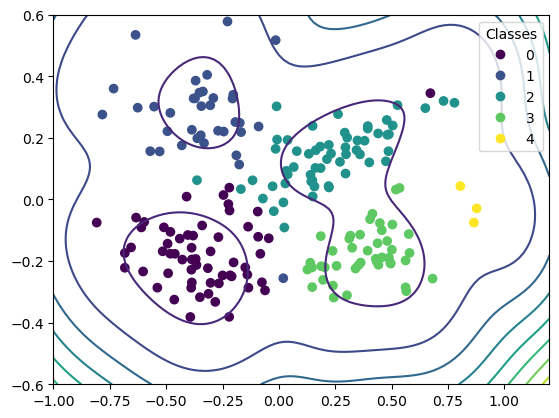

In [14]:
# plotting
x = np.linspace(-1, 1.2, 100)
y = np.linspace(-0.6, 0.6, 100)
X,Y = meshgrid(x, y)
Z = np.array([[potential_eqn(np.array([i,j]), df_crabs[['pca_{}'.format(component_for_x), 'pca_{}'.format(component_for_y)]].to_numpy(), my_sigma) for i in x] for j in y])

fig, ax = plt.subplots(1, 1) 
ax.contour(X, Y, Z) 
scatter = ax.scatter(df_crabs['pca_{}'.format(component_for_x)].to_numpy(), df_crabs['pca_{}'.format(component_for_y)].to_numpy(), c=crab_label)
ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
plt.show()

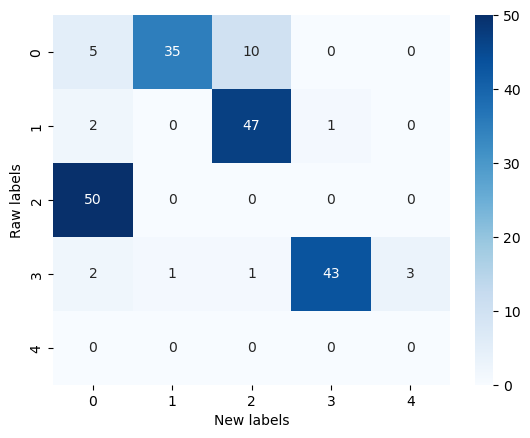

In [15]:
cf_matrix = confusion_matrix(df_crabs['true_label'], df_crabs['recon_label'])
ax= plt.subplot()
sns.heatmap(cf_matrix, cmap='Blues', annot=True)
ax.set_xlabel('New labels');ax.set_ylabel('Raw labels'); 